In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set_context('talk')
%matplotlib inline

from helpers import *

In [2]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

def load_data(mani_dir):
    paths = np.sort(np.array(os.listdir(mani_dir)))
    data = np.array([loadmat(mani_dir+path) for path in paths])
    return paths, data

def format_str(s0):
    s1 = ''
    counter = 0
    for l in s0:
        if l == '_':
            counter += 1
        if l == '_' and counter in [2,4,6] :
            l = '-'
        s1+=l
    return s1

def get_layer_type(path, types):
    for t in types:
        if t in path:
            return t

def frame_constructor(paths, data, key, tag=None, mean=False):
#     layers = [path.split('-')[1] for path in paths]
    perm_seed = [path.split('_')[0] for path in paths]
    ft_size = [path.split('_')[1] for path in paths]
    lnum = [path.split('_')[4] for path in paths]
    coding = [path.split('_')[3] for path in paths]
#     layers = np.array([format_str(path).split('_')[3] for path in paths])
#     epochs = np.array([int(format_str(path).split('_')[1].split('-')[1]) for path in paths])
    image_set = np.array([path.split('_')[0] for path in paths])
    
    data_vec = np.array([np.squeeze(datum[key]) for datum in data])
    if mean:
        data_vec = np.mean(data_vec,axis=1)
    data_vec = np.atleast_2d(data_vec)    
    print(data_vec.shape)
    if data_vec.shape[0]<data_vec.shape[1]:
        data_vec = data_vec.T
        
    df = pd.DataFrame(
        columns=[
            'path', 
            'image set', 
            'layer number',
            'coding',
            'perm seed', 
            'feature size', 
            'value', 
            'measure',
            'tag'
        ], 
        data=np.array([
            np.repeat([paths],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([image_set],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([lnum],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([coding],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([perm_seed],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([ft_size],data_vec.shape[-1],axis=0).T.reshape(-1),
            data_vec.reshape(-1),
            np.repeat(key,data_vec.size),
            np.repeat(tag,data_vec.size)
        ]).T
    )
    
    types = ['MaxPool2d', 'Conv2d', 'ReLU', 'Linear', 'BatchNorm2d']
    df['type'] = df.path.apply(lambda x: get_layer_type(x, types))
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df['perm seed'] = pd.to_numeric(df['perm seed'], errors='coerce')
    df['feature size'] = pd.to_numeric(df['feature size'], errors='coerce')
    df['layer number'] = pd.to_numeric(df['layer number'], errors='coerce')
    df.loc[df['coding']=='classifier', 'layer number'] = df.loc[
        df['coding']=='classifier', 'layer number'] + df[
        (df['coding']=='features') & (df['image set']=='train')
    ].shape[0]
    return df

def multi_frame_constructor(mani_dirs, tags, measures):
    df = None
    for i, mani_dir in enumerate(mani_dirs):
        paths, data = load_data(mani_dir)
        for measure in measures:
            mean = True
            if measure == "CCcorr": mean = False
            if type(df) == type(None):
                df = frame_constructor(paths, data, measure, tag=tags[i], mean=mean)
            else:
                df = df.append(frame_constructor(paths, data, measure, tag=tags[i], mean=mean))
    return df
  
def make_contiguous(a):
    return np.arange(len(a))
    
def display(df, measure, coding, title, dims=(12,7)):
    unique_tags = np.unique(df.tag.values)
    data = df[
        (df['measure']==measure)
#         &(df['coding']==coding)
    ].sort_values(by=['layer number']).copy()
    
    for unique_tag in unique_tags:
        contiguous_layer_num = make_contiguous(data[data['tag']==unique_tag]['layer number'].values)
        data.loc[data['tag']==unique_tag, 'layer number'] = contiguous_layer_num
    
    # re sort by layer number, as everything will be shifted if one set was not contiguous
    data = data.sort_values(by=['layer number'])
    
    fig, ax = plt.subplots(figsize=dims)

    ax = sns.scatterplot(x="layer number", 
                         y="value", 
                         ax=ax,
                         hue="tag",
                         data=data)
    ax.set_title(title)
    ax.set_ylabel('mean {}'.format(measure.replace('_vec','')))
    ax.set_xticks(ticks=range(len(data.type)/len(unique_tags)))
    ax.set_xticklabels(data.type.values[::len(unique_tags)],rotation=90)
    ax.set_xlabel('layer type')
    return data

def get_losses(log, epochs=300):
    f = open(log)
    val_loss = 100-np.array([float(line.split(' ')[3]) for line in f if " * Prec@1" in line])
    f = open(log)
    train_loss = np.array([float(line.split(" ")[8]) for line in f if ("Prec@1" in line) & ("Epoch" in line)])
    step_num = len(train_loss)/epochs
    train_loss = 100-np.array([train_loss[i*step_num:i*step_num+step_num].mean() for i in range(epochs)])
    
    return train_loss, val_loss

def plot_losses(log):
    train_loss, val_loss = get_losses(log)
    ax = pd.DataFrame(columns=['training error', 'validation error'], data=np.array([train_loss, val_loss]).T).plot()
    ax.set_xlabel('Epoch number')
    ax.set_ylabel('Error (%)')
    ax.set_title('Training curves')

## plot overlaid 

(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)


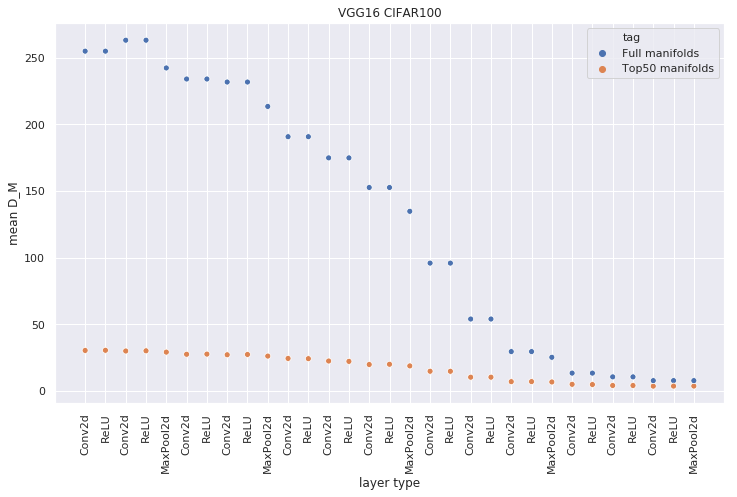

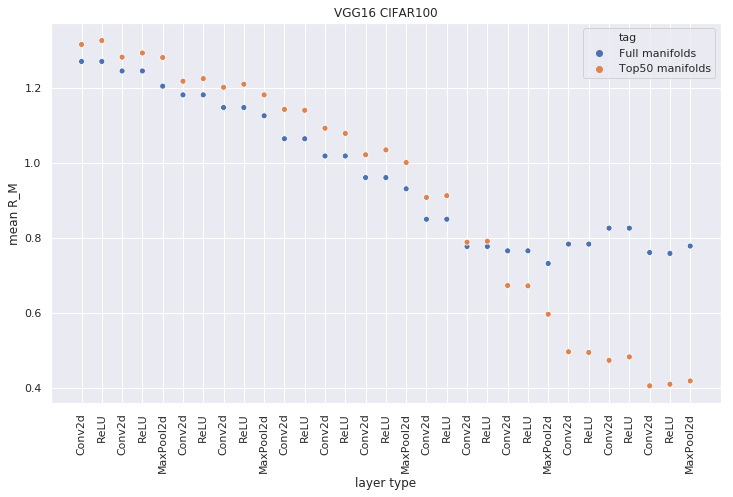

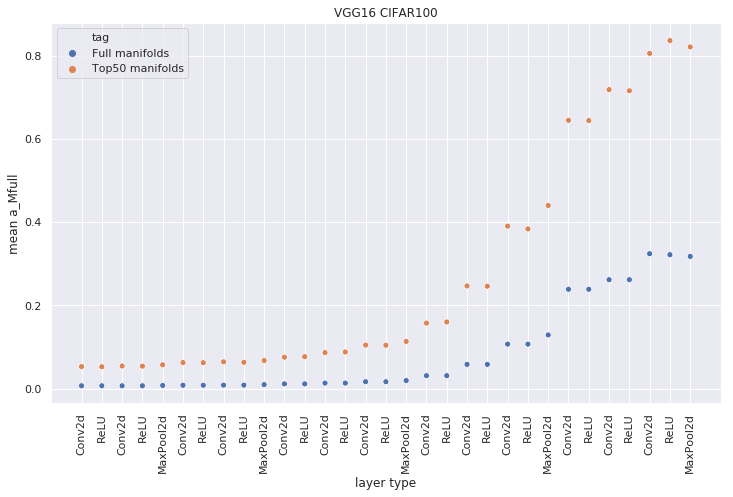

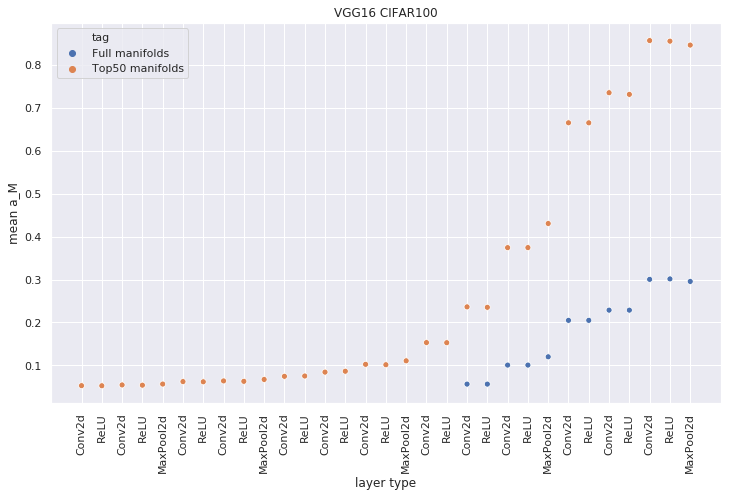

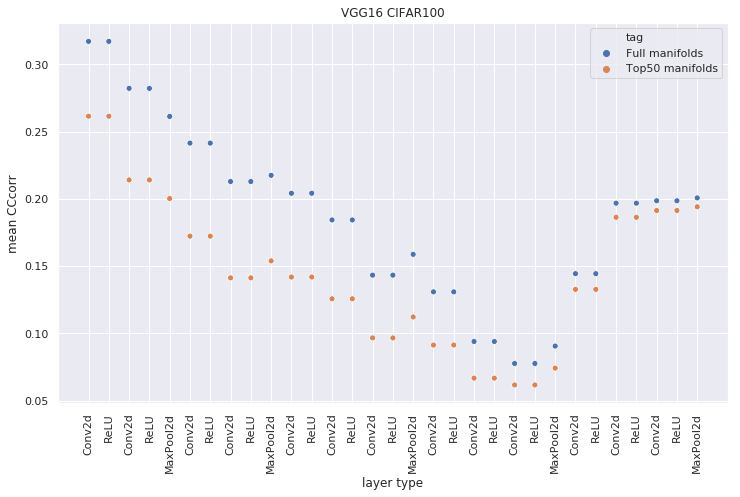

In [187]:
mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_full/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = frame_constructor(paths, data, 'D_M_vec', tag='Full manifolds', mean=True)
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Full manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Full manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Full manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Full manifolds'))

mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_top50/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = df.append(frame_constructor(paths, data, 'D_M_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Top50 manifolds'))

for v in ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']:
    display(df, v, 'features', 'VGG16 CIFAR100')

## display lots of manifold measures

## best, worst, full

(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)


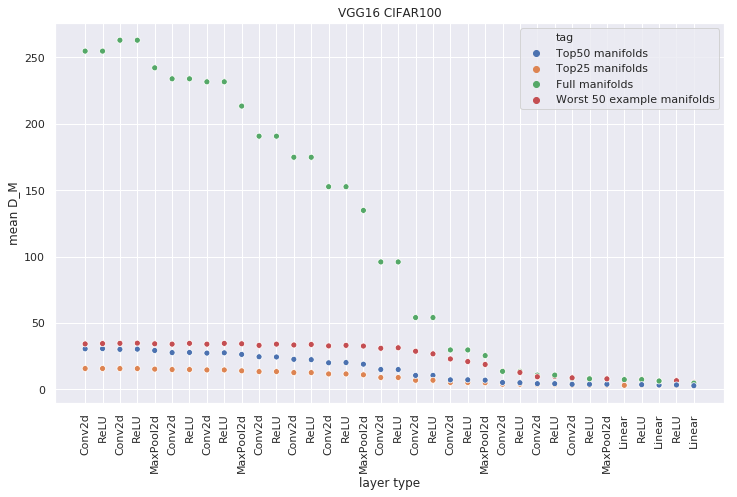

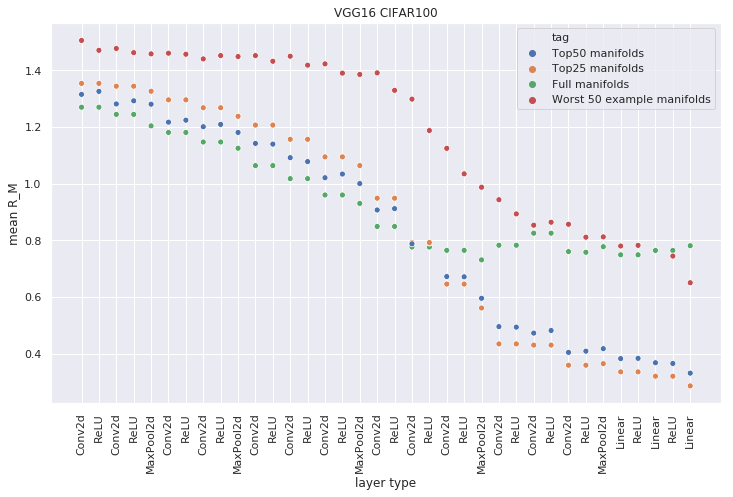

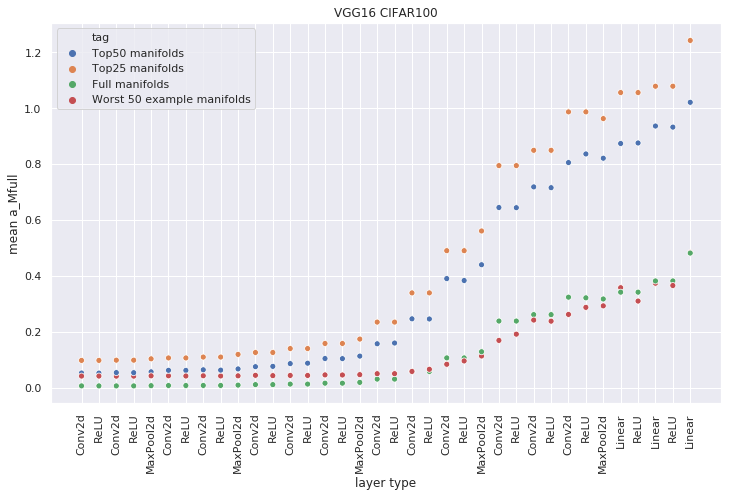

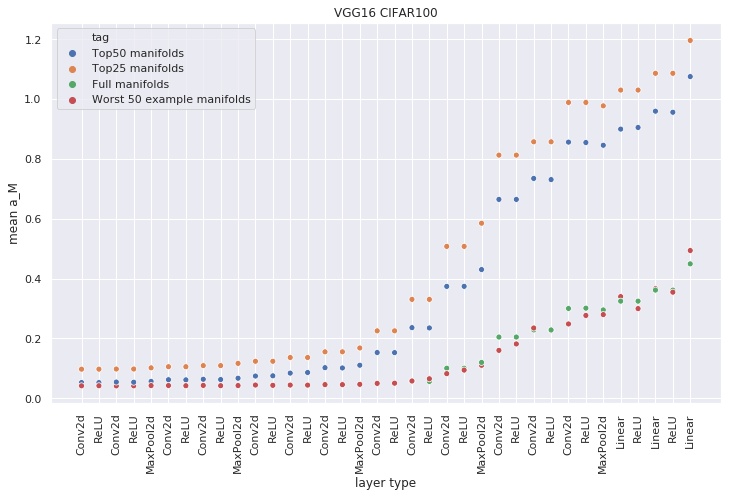

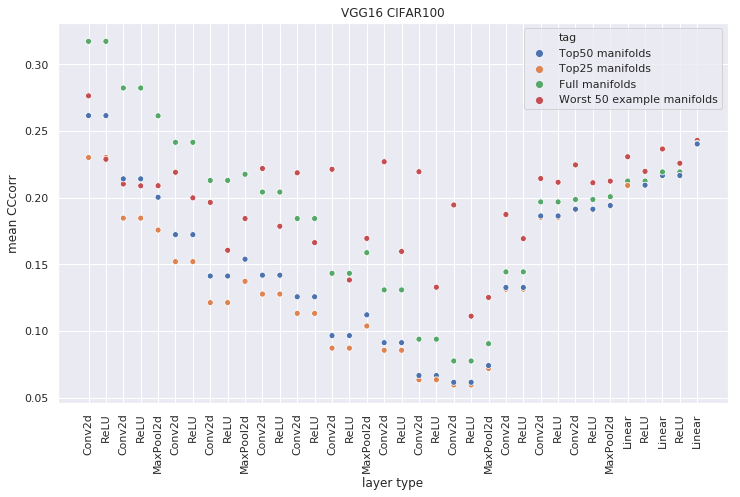

In [43]:
mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_full/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = frame_constructor(paths, data, 'D_M_vec', tag='Full manifolds', mean=True)
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Full manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Full manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Full manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Full manifolds'))

mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_top50/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = df.append(frame_constructor(paths, data, 'D_M_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Top50 manifolds'))

mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_25/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = df.append(frame_constructor(paths, data, 'D_M_vec', tag='Top25 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Top25 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Top25 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Top25 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Top25 manifolds'))

mani_dir = '../vgg-feature-gen/CIFAR100/manifold_vgg16_reverse_bsoftmax_50/'
paths, data = load_data(mani_dir)
# paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = df.append(frame_constructor(paths, data, 'D_M_vec', tag='Worst 50 example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Worst 50 example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Worst 50 example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Worst 50 example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Worst 50 example manifolds'))

for v in ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']:
    display(df, v, 'features', 'VGG16 CIFAR100')

## best, worst, random, untrained

(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)


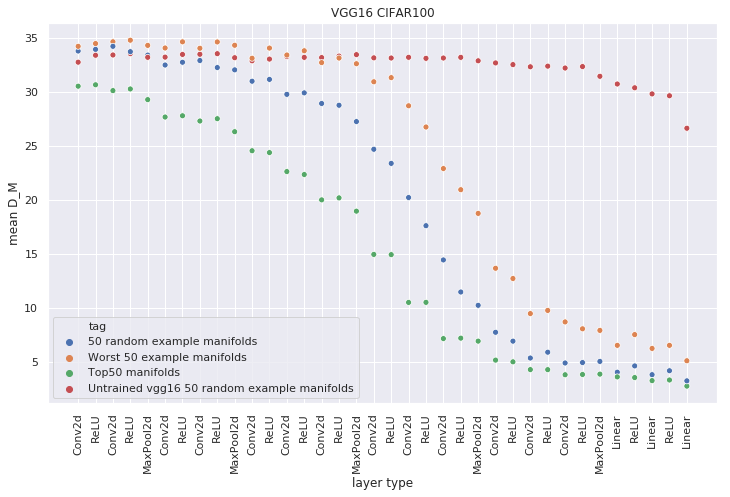

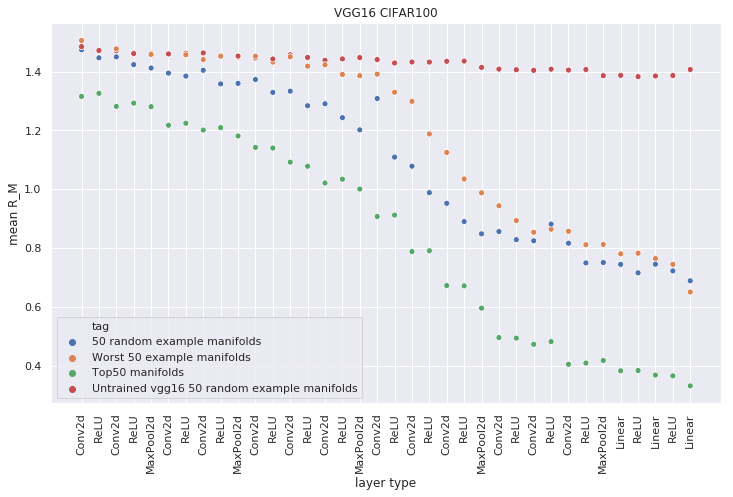

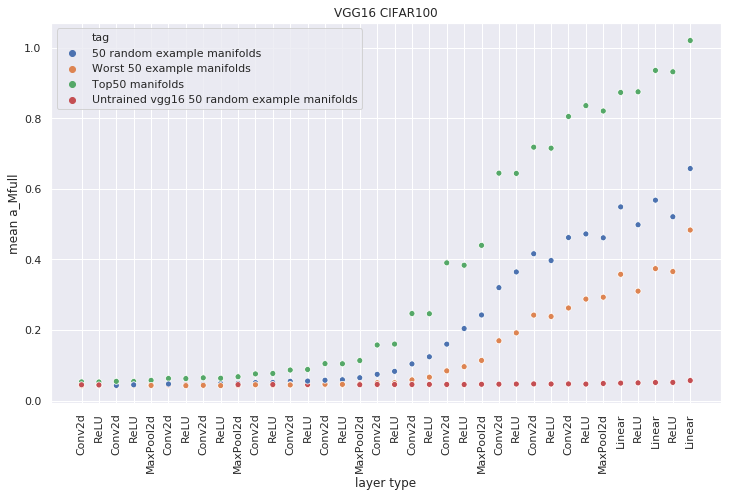

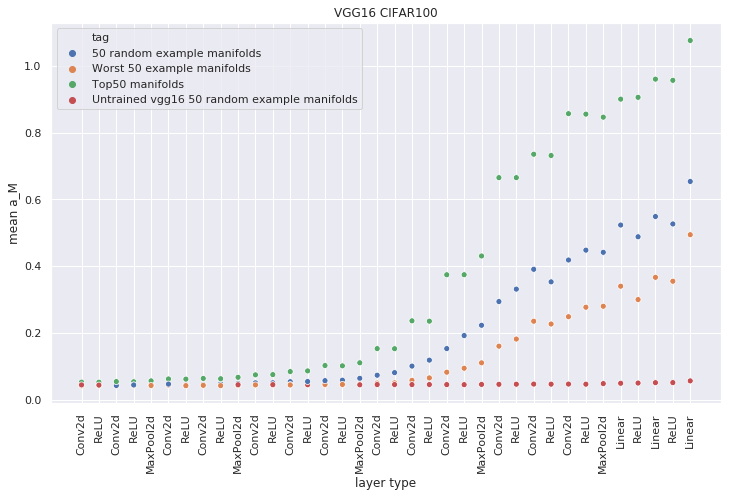

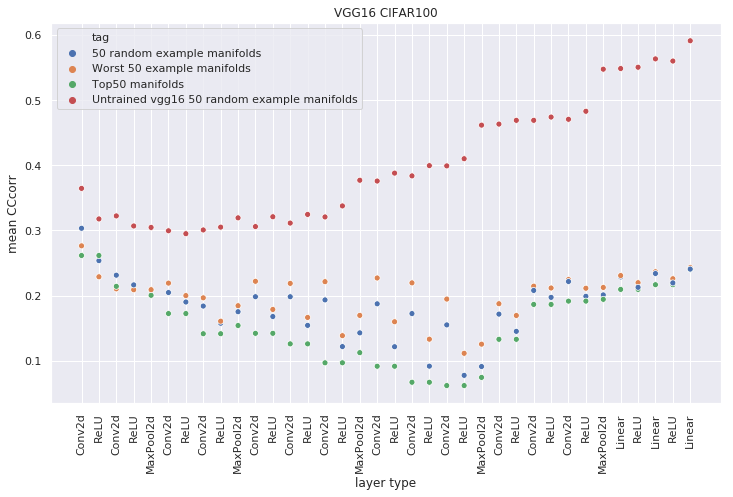

In [104]:
mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_top50/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = frame_constructor(paths, data, 'D_M_vec', tag='Top50 manifolds', mean=True)
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Top50 manifolds'))

mani_dir = '../vgg-feature-gen/CIFAR100/manifold_vgg16_randperm_example_selection/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = df.append(frame_constructor(paths, data, 'D_M_vec', tag='50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='50 random example manifolds'))

mani_dir = '../vgg-feature-gen/CIFAR100/manifold_vgg16_reverse_bsoftmax_50/'
paths, data = load_data(mani_dir)
# paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = df.append(frame_constructor(paths, data, 'D_M_vec', tag='Worst 50 example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Worst 50 example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Worst 50 example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Worst 50 example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Worst 50 example manifolds'))


mani_dir = '../vgg-feature-gen/CIFAR100/manifold_feature_rand_vgg16_rand_example_seed1/'
paths, data = load_data(mani_dir)
# paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = df.append(frame_constructor(paths, data, 'D_M_vec', tag='Untrained vgg16 50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Untrained vgg16 50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Untrained vgg16 50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Untrained vgg16 50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Untrained vgg16 50 random example manifolds'))

for v in ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']:
    display(df, v, 'features', 'VGG16 CIFAR100')

## train vs val -- no dropout, no batchnorm

In [103]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

def load_data(mani_dir):
    paths = np.sort(np.array(os.listdir(mani_dir)))
    data = np.array([loadmat(mani_dir+path) for path in paths])
    return paths, data

def format_str(s0):
    s1 = ''
    counter = 0
    for l in s0:
        if l == '_':
            counter += 1
        if l == '_' and counter in [2,4,6] :
            l = '-'
        s1+=l
    return s1

def get_layer_type(path, types):
    for t in types:
        if t in path:
            return t

def frame_constructor(paths, data, key, tag=None, mean=False):
#     layers = [path.split('-')[1] for path in paths]
    perm_seed = [path.split('_')[0] for path in paths]
    ft_size = [path.split('_')[1] for path in paths]
    lnum = [path.split('_')[4] for path in paths]
    coding = [path.split('_')[3] for path in paths]
#     layers = np.array([format_str(path).split('_')[3] for path in paths])
#     epochs = np.array([int(format_str(path).split('_')[1].split('-')[1]) for path in paths])
    image_set = np.array([path.split('_')[0] for path in paths])
    
    data_vec = np.array([np.squeeze(datum[key]) for datum in data])
    if mean:
        data_vec = np.mean(data_vec,axis=1)
    data_vec = np.atleast_2d(data_vec)    
    print(data_vec.shape)
    if data_vec.shape[0]<data_vec.shape[1]:
        data_vec = data_vec.T
        
    df = pd.DataFrame(
        columns=[
            'path', 
            'image set', 
            'layer number',
            'coding',
            'perm seed', 
            'feature size', 
            'value', 
            'measure',
            'tag'
        ], 
        data=np.array([
            np.repeat([paths],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([image_set],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([lnum],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([coding],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([perm_seed],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([ft_size],data_vec.shape[-1],axis=0).T.reshape(-1),
            data_vec.reshape(-1),
            np.repeat(key,data_vec.size),
            np.repeat(tag,data_vec.size)
        ]).T
    )
    
    types = ['MaxPool2d', 'Conv2d', 'ReLU', 'Linear', 'BatchNorm2d']
    df['type'] = df.path.apply(lambda x: get_layer_type(x, types))
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df['perm seed'] = pd.to_numeric(df['perm seed'], errors='coerce')
    df['feature size'] = pd.to_numeric(df['feature size'], errors='coerce')
    df['layer number'] = pd.to_numeric(df['layer number'], errors='coerce')
    df.loc[df['coding']=='classifier', 'layer number'] = df.loc[
        df['coding']=='classifier', 'layer number'] + df[
        (df['coding']=='features') & (df['image set']=='train')
    ].shape[0]
    return df

def multi_frame_constructor(mani_dirs, tags, measures):
    df = None
    for i, mani_dir in enumerate(mani_dirs):
        paths, data = load_data(mani_dir)
        for measure in measures:
            mean = True
            if measure == "CCcorr": mean = False
            if type(df) == type(None):
                df = frame_constructor(paths, data, measure, tag=tags[i], mean=mean)
            else:
                df = df.append(frame_constructor(paths, data, measure, tag=tags[i], mean=mean))
    return df
  
def make_contiguous(a):
    return np.arange(len(a))
    
def display(df, measure, coding, title, dims=(12,7)):
    unique_tags = np.unique(df.tag.values)
    data = df[
        (df['measure']==measure)
#         &(df['coding']==coding)
    ].sort_values(by=['layer number']).copy()
    
    for unique_tag in unique_tags:
        contiguous_layer_num = make_contiguous(data[data['tag']==unique_tag]['layer number'].values)
        data.loc[data['tag']==unique_tag, 'layer number'] = contiguous_layer_num
    
    # re sort by layer number, as everything will be shifted if one set was not contiguous
    data = data.sort_values(by=['layer number'])
    
    fig, ax = plt.subplots(figsize=dims)

    ax = sns.scatterplot(x="layer number", 
                         y="value", 
                         ax=ax,
                         hue="tag",
                         data=data)
    ax.set_title(title)
    ax.set_ylabel('mean {}'.format(measure.replace('_vec','')))
    ax.set_xticks(ticks=range(len(data.type)/len(unique_tags)))
    ax.set_xticklabels(data.type.values[::len(unique_tags)],rotation=90)
    ax.set_xlabel('layer type')
    return data

def get_losses(log, epochs=300):
    f = open(log)
    val_loss = 100-np.array([float(line.split(' ')[3]) for line in f if " * Prec@1" in line])
    f = open(log)
    train_loss = np.array([float(line.split(" ")[8]) for line in f if ("Prec@1" in line) & ("Epoch" in line)])
    step_num = len(train_loss)/epochs
    train_loss = 100-np.array([train_loss[i*step_num:i*step_num+step_num].mean() for i in range(epochs)])
    
    return train_loss, val_loss

def plot_losses(log):
    train_loss, val_loss = get_losses(log)
    ax = pd.DataFrame(columns=['training error', 'validation error'], data=np.array([train_loss, val_loss]).T).plot()
    ax.set_xlabel('Epoch number')
    ax.set_ylabel('Error (%)')
    ax.set_title('Training curves')

(1, 72)
(1, 72)
(1, 72)
(1, 72)
(1, 72)


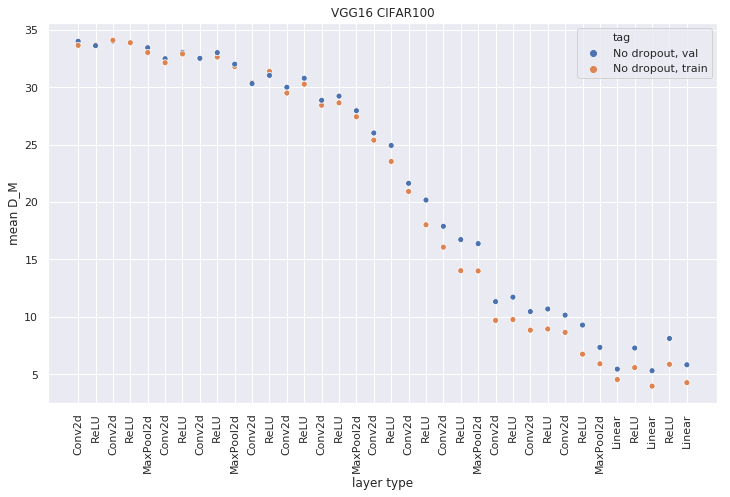

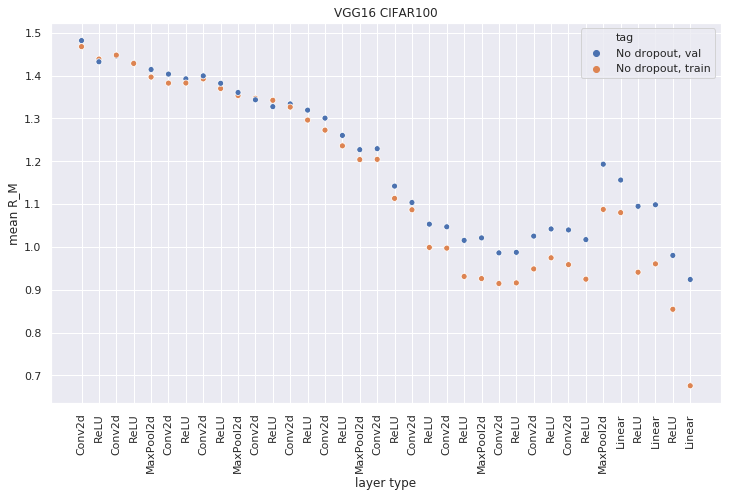

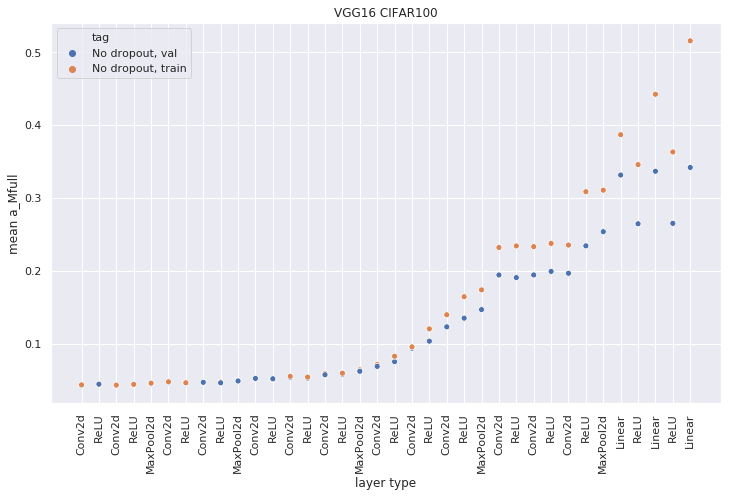

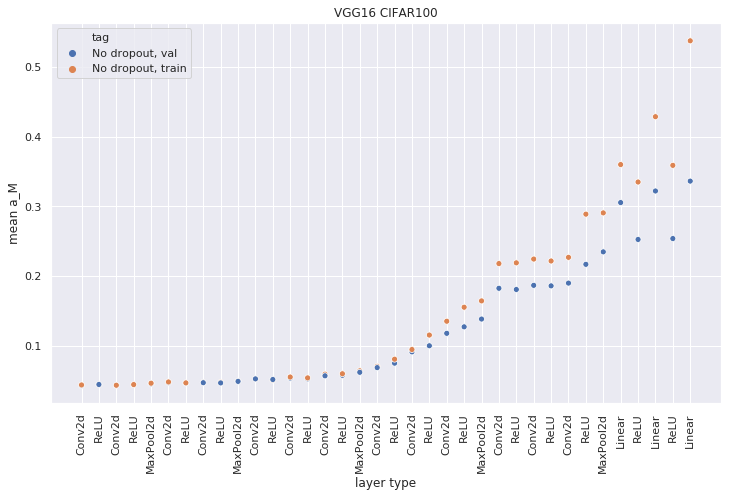

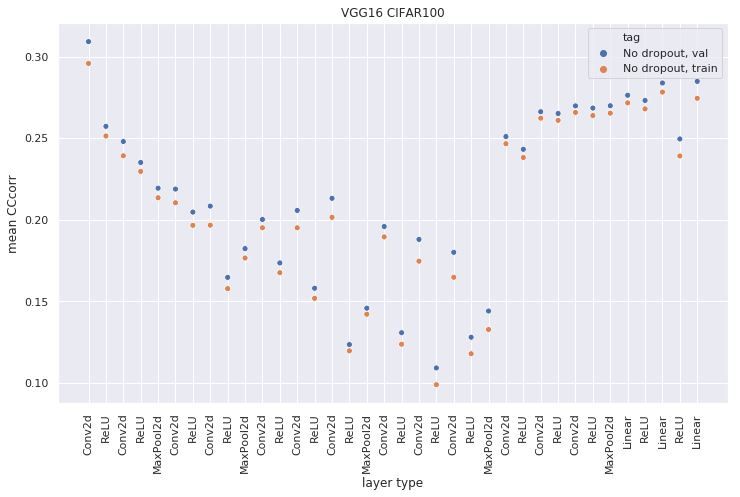

In [105]:
## redo w/ new random sorted examples
mani_dir = '../vgg-feature-gen/CIFAR100/manifold_formatted-drop_0-vgg16-features-sort_random-seed_0/'
paths, data = load_data(mani_dir)

tag = 'No dropout, '
df = frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True)
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))

df['tag'] = df['tag']+df['image set']

for v in ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']:
    display(df, v, 'features', 'VGG16 CIFAR100')

## dropout effect on features -- train

(1, 71)
(1, 71)
(1, 71)
(1, 71)
(1, 71)
(1, 72)
(1, 72)
(1, 72)
(1, 72)
(1, 72)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 71)
(1, 71)
(1, 71)
(1, 71)
(1, 71)


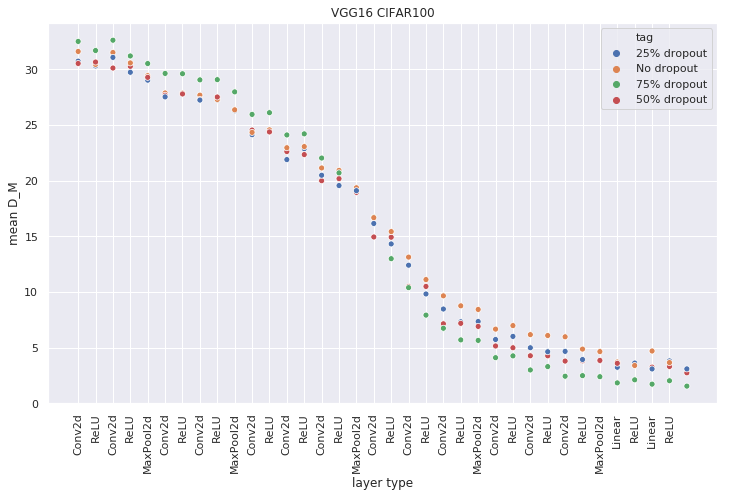

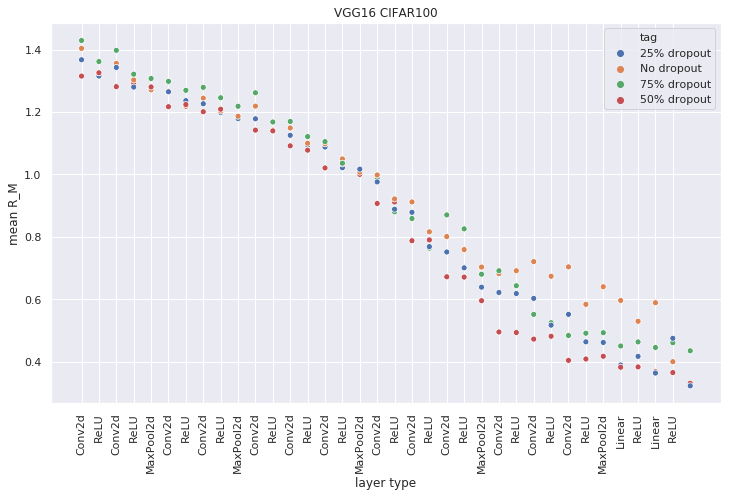

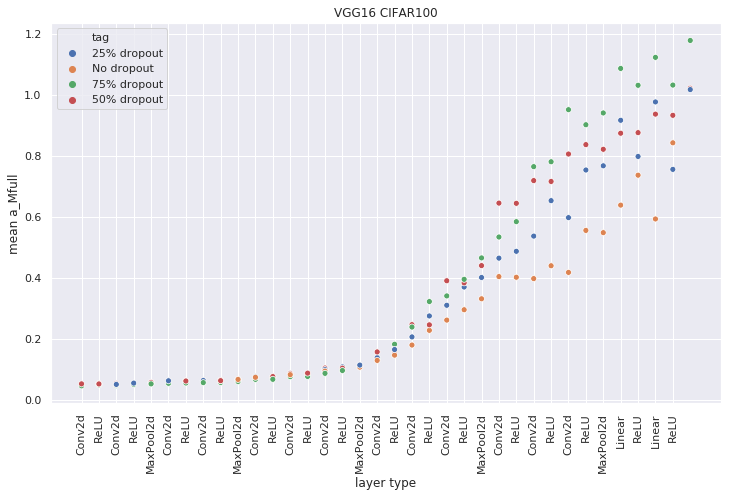

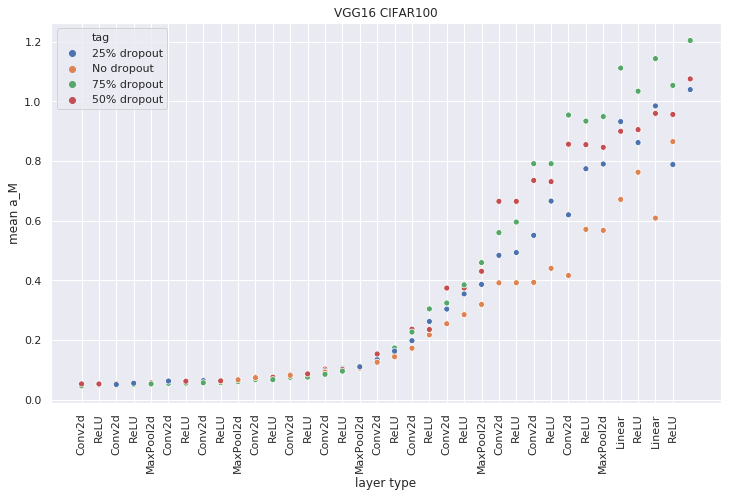

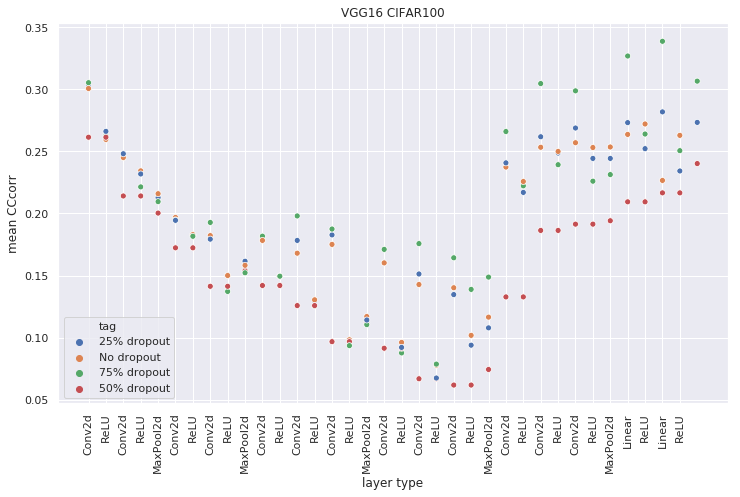

In [106]:
mani_dir = '../vgg-feature-gen/CIFAR100/manifold_formatted_drop_0_feature_vgg16_seed0/'
paths, data = load_data(mani_dir)

tag = 'No dropout'
df = frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True)
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))


mani_dir = '../vgg-feature-gen/CIFAR100/manifold_formatted-drop_25-vgg16-features-sort_betasoftmax-seed_0/'
paths, data = load_data(mani_dir)

tag = '25% dropout'
df = df.append(frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))


mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_top50/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

tag = '50% dropout'
df = df.append(frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))


mani_dir = '../vgg-feature-gen/CIFAR100/manifold_formatted_drop_75_feature_vgg16_seed0/'
paths, data = load_data(mani_dir)

tag = '75% dropout'
df = df.append(frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))


df_filtered = df[df['image set']=='train']

for v in ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']:
    display(df_filtered, v, 'features', 'VGG16 CIFAR100')

## dropout effect on features -- validation

(1, 71)
(1, 71)
(1, 71)
(1, 71)
(1, 71)
(1, 72)
(1, 72)
(1, 72)
(1, 72)
(1, 72)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 71)
(1, 71)
(1, 71)
(1, 71)
(1, 71)


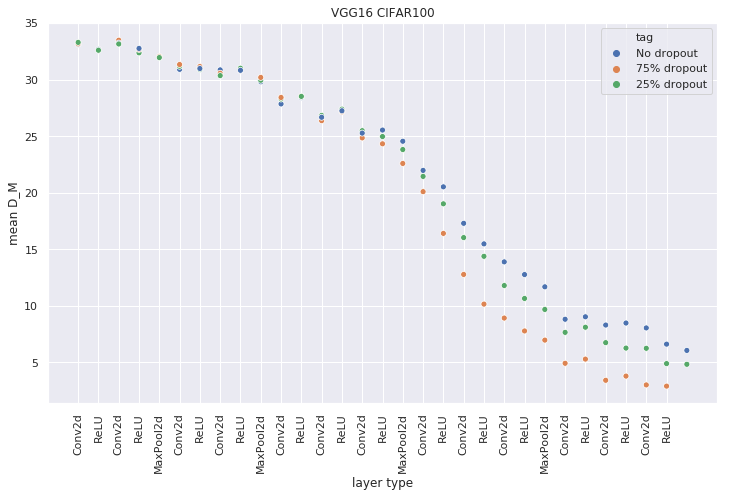

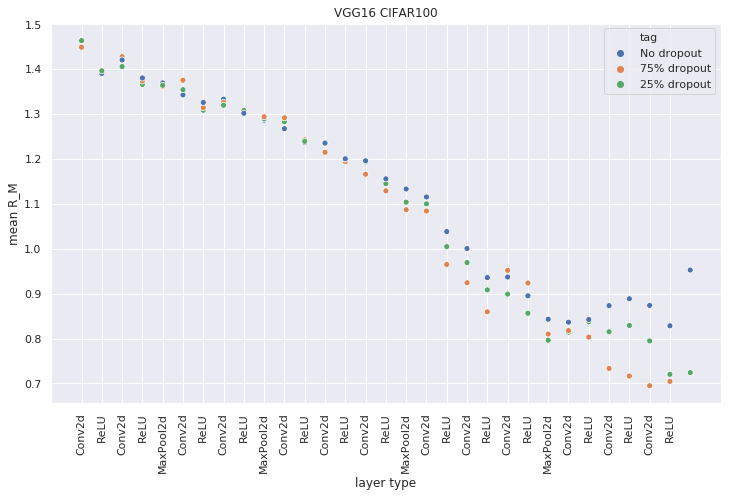

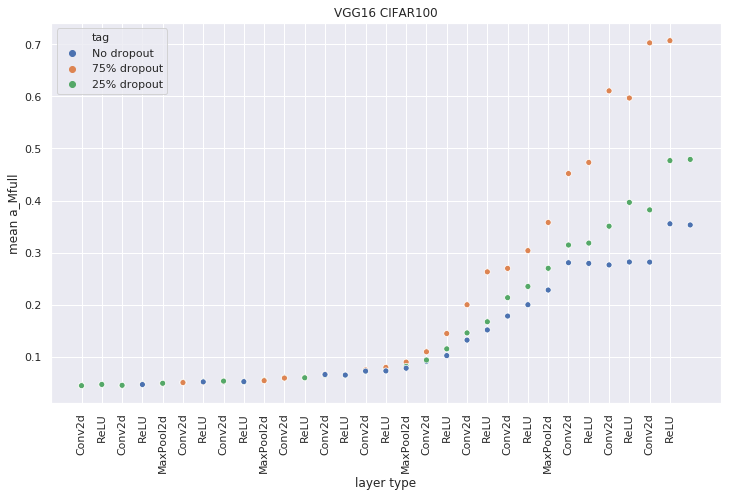

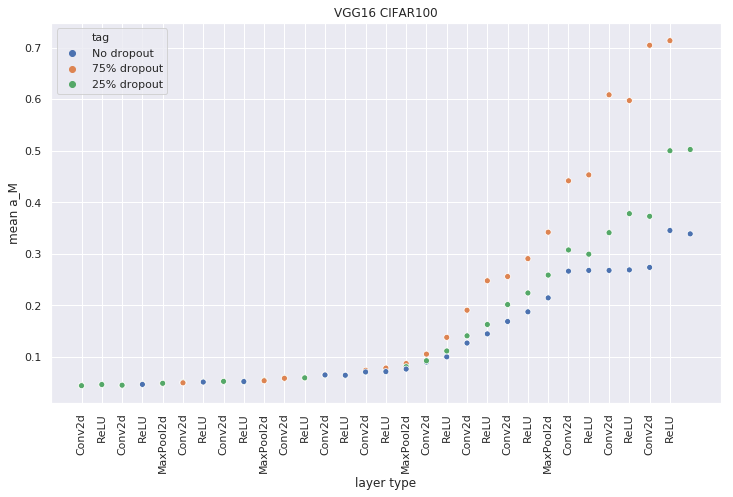

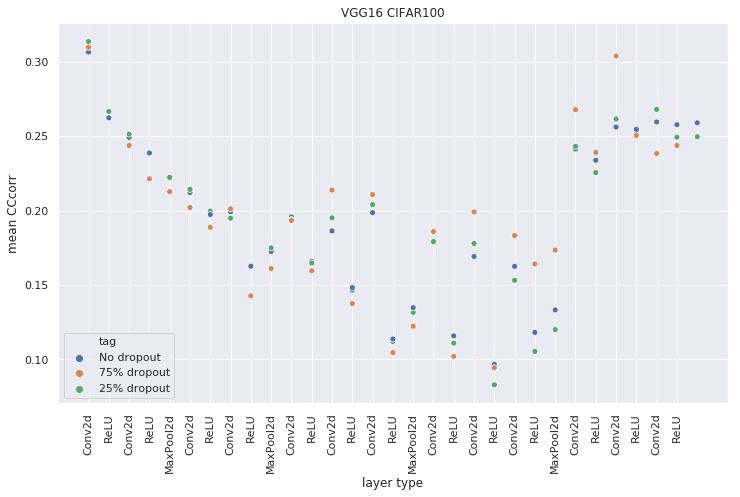

In [15]:
### need to do val on drop 50.. probably re do it entirely.


mani_dir = '../vgg-feature-gen/CIFAR100/manifold_formatted_drop_0_feature_vgg16_seed0/'
paths, data = load_data(mani_dir)

tag = 'No dropout'
df = frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True)
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))

mani_dir = '../vgg-feature-gen/CIFAR100/manifold_formatted-drop_25-vgg16-features-sort_betasoftmax-seed_0/'
paths, data = load_data(mani_dir)

tag = '25% dropout'
df = df.append(frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))

mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_top50/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

tag = '50% dropout'
df = df.append(frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))


mani_dir = '../vgg-feature-gen/CIFAR100/manifold_formatted_drop_75_feature_vgg16_seed0/'
paths, data = load_data(mani_dir)

tag = '75% dropout'
df = df.append(frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))


df_filtered = df[df['image set']=='val']

for v in ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']:
    display(df_filtered, v, 'features', 'VGG16 CIFAR100')

## a look at batchnorm -- ooh la la??

In [121]:
df['path'].loc[10]

10    train_ep_300_features_14_Conv2d128,_256,_kerne...
10    train_ep_300_features_14_Conv2d128,_256,_kerne...
10    train_ep_300_features_14_Conv2d128,_256,_kerne...
10    train_ep_300_features_14_Conv2d128,_256,_kerne...
10    train_ep_300_features_14_Conv2d128,_256,_kerne...
Name: path, dtype: object

(1, 98)
(1, 98)
(1, 98)
(1, 98)
(1, 98)


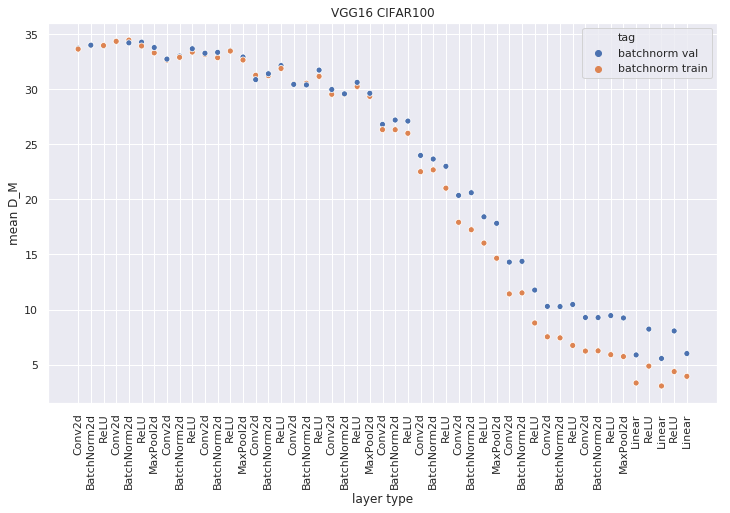

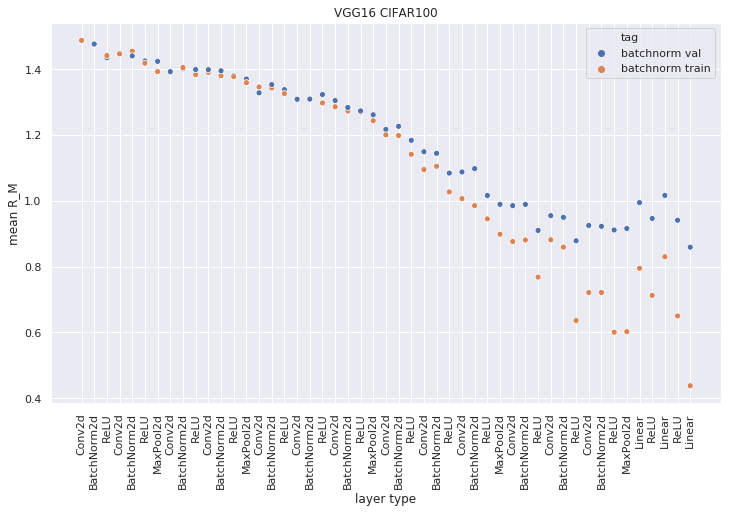

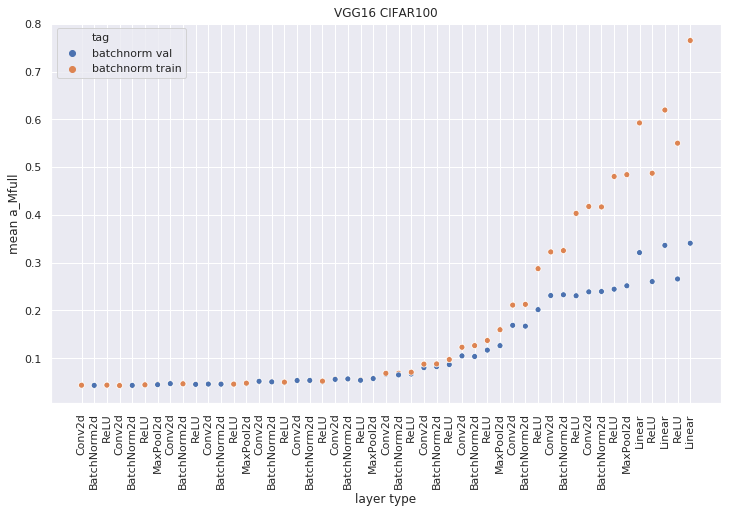

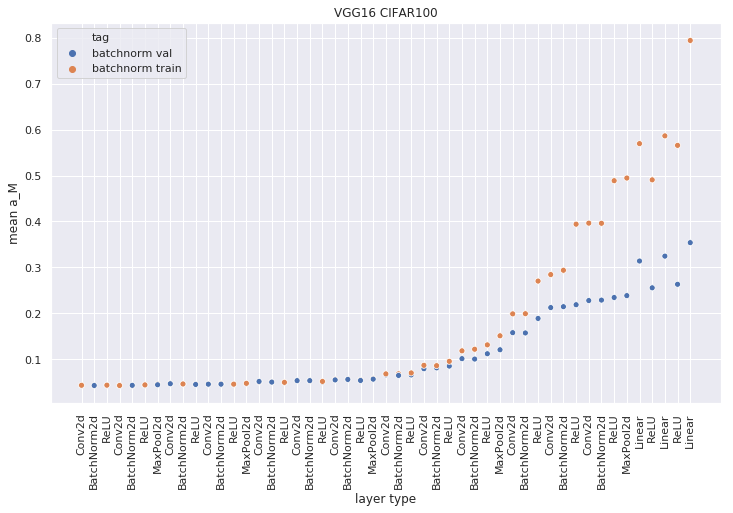

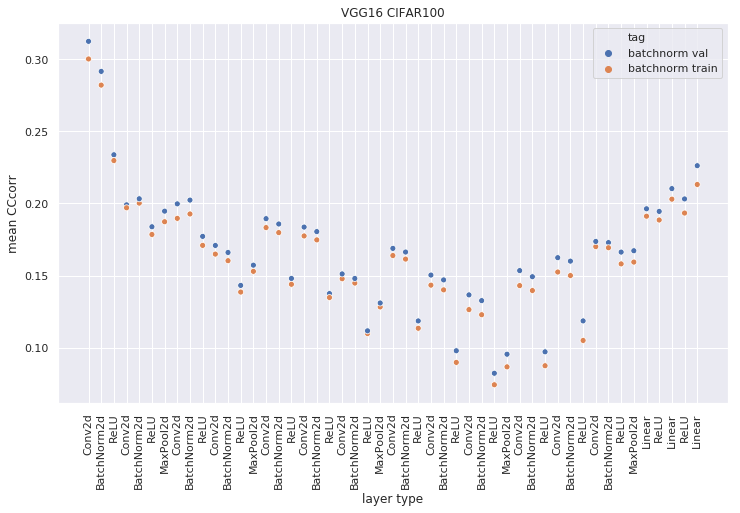

In [118]:
measures = ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']
mani_dirs = [
    '../vgg-feature-gen/CIFAR100/manifold_formatted-drop_0-vgg16_bn-features-sort_random-seed_0/'
]
tags = [
    'batchnorm '
]

df = multi_frame_constructor(mani_dirs, tags, measures)

# df_filtered = df[(df['image set']=='train')]
df['tag'] = df['tag']+df['image set']

for measure in measures:
    display(df, measure, 'features', 'VGG16 CIFAR100')

In [86]:
data.append(data.loc[0])

,path,image set,layer number,coding,perm seed,feature size,value,measure,tag,type
5,"train_ep_300_features_0_Conv2d3,_64,_kernel_si...",train,0,features,NaN,NaN,0.295808,CCcorr,no batchnorm,Conv2d
5,"train_ep_300_features_0_Conv2d3,_64,_kernel_si...",train,0,features,NaN,NaN,0.300140,CCcorr,batchnorm,Conv2d
16,"train_ep_300_features_1_BatchNorm2d64,_eps=1e-...",train,1,features,NaN,NaN,0.282028,CCcorr,batchnorm,BatchNorm2d
16,train_ep_300_features_1_ReLUinplace.h5,train,1,features,NaN,NaN,0.251348,CCcorr,no batchnorm,ReLU
27,"train_ep_300_features_2_Conv2d64,_64,_kernel_s...",train,2,features,NaN,NaN,0.239212,CCcorr,no batchnorm,Conv2d
27,train_ep_300_features_2_ReLUinplace.h5,train,2,features,NaN,NaN,0.229721,CCcorr,batchnorm,ReLU
38,"train_ep_300_features_3_Conv2d64,_64,_kernel_s...",train,3,features,NaN,NaN,0.196962,CCcorr,batchnorm,Conv2d
29,train_ep_300_features_3_ReLUinplace.h5,train,3,features,NaN,NaN,0.229628,CCcorr,no batchnorm,ReLU
30,train_ep_300_features_4_MaxPool2dkernel_size=2...,train,4,features,NaN,NaN,0.213509,CCcorr,no batchnorm,MaxPool2d
43,"train_ep_300_features_4_BatchNorm2d64,_eps=1e-...",train,4,features,NaN,NaN,0.200216,CCcorr,batchnorm,BatchNorm2d


(1, 72)
(1, 72)
(1, 72)
(1, 72)
(1, 72)
(1, 98)
(1, 98)
(1, 98)
(1, 98)
(1, 98)


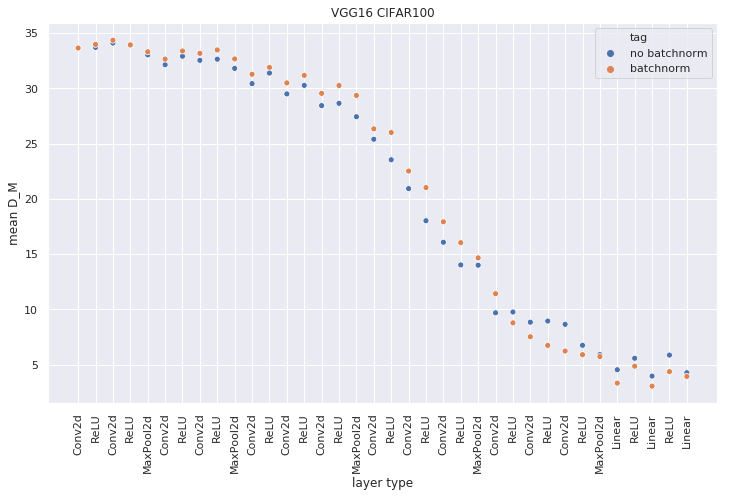

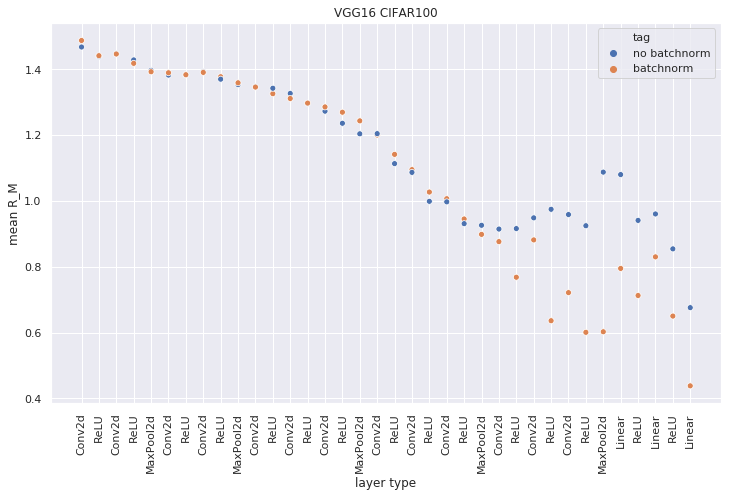

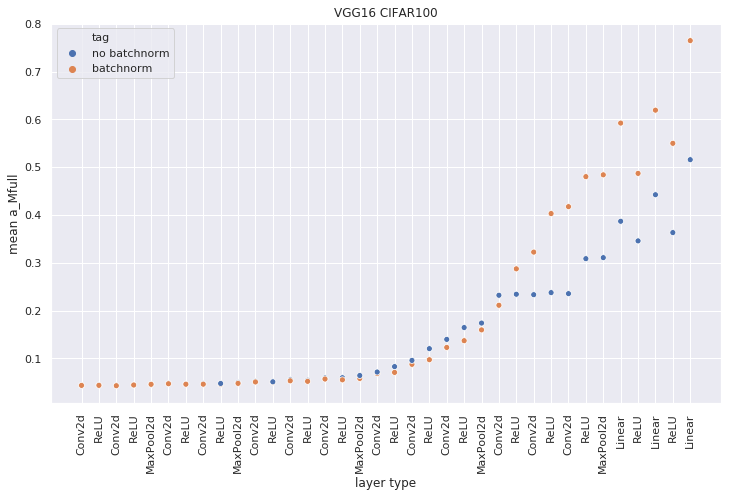

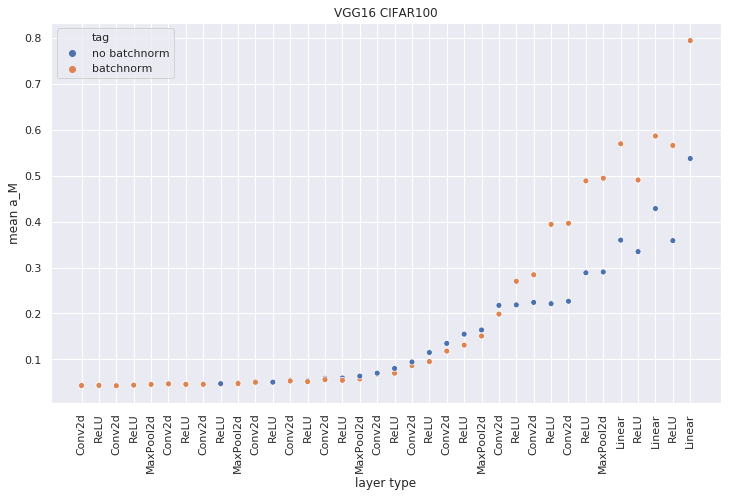

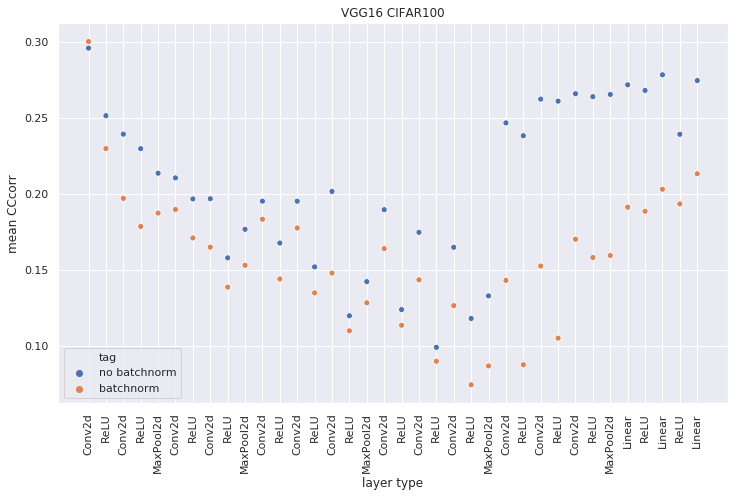

In [109]:
measures = ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']
mani_dirs = [
    '../vgg-feature-gen/CIFAR100/manifold_formatted-drop_0-vgg16-features-sort_random-seed_0/',
    '../vgg-feature-gen/CIFAR100/manifold_formatted-drop_0-vgg16_bn-features-sort_random-seed_0/'
]
tags = [
    'no batchnorm',
    'batchnorm'
]

df = multi_frame_constructor(mani_dirs, tags, measures)

df_filtered = df[(df['image set']=='train')&(df['type']!='BatchNorm2d')]
#df_filtered = df[(df['image set']=='train')]

for measure in measures:
    data = display(df_filtered, measure, 'features', 'VGG16 CIFAR100')

(1, 98)
(1, 98)
(1, 98)
(1, 98)
(1, 98)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)


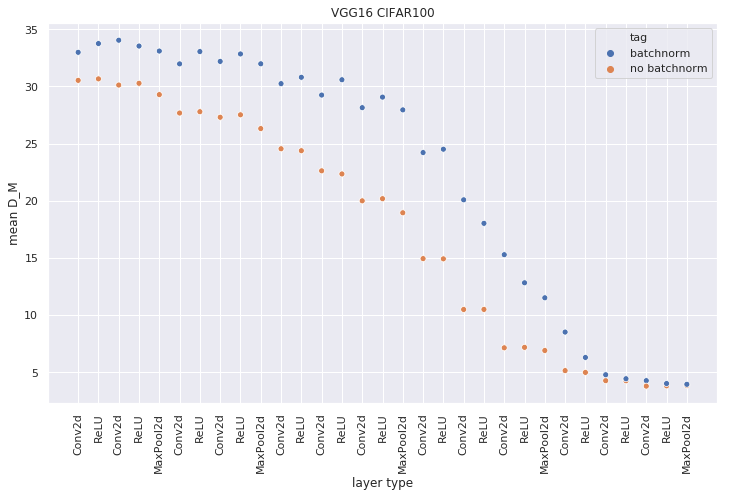

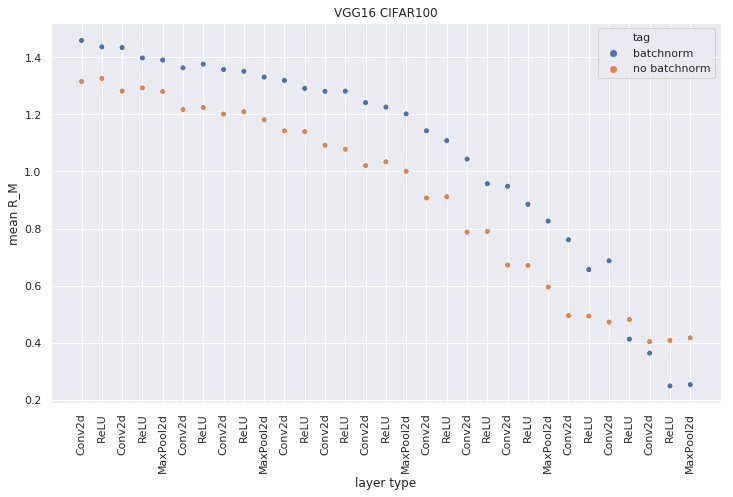

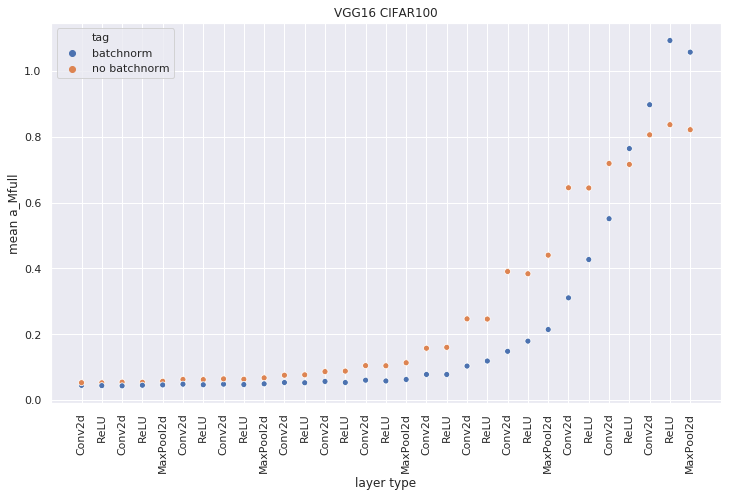

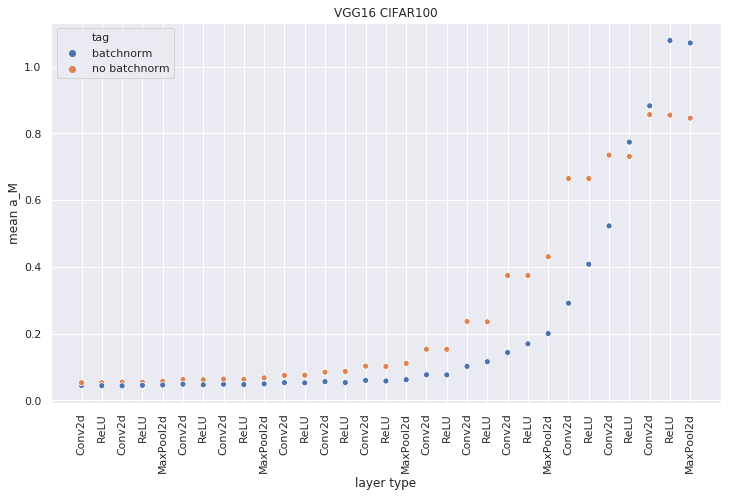

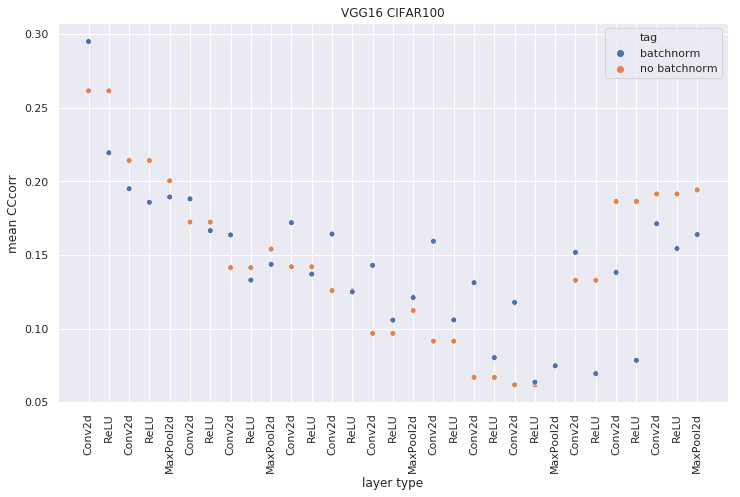

In [192]:
mani_dir = '../vgg-feature-gen/CIFAR100/manifold_formatted_drop_50_feature_vgg16_bn_seed0/'
paths, data = load_data(mani_dir)

tag = 'batchnorm'
df = frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True)
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))

mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_top50/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

tag = 'no batchnorm'
df = df.append(frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))

df_filtered = df[(df['image set']=='train')&(df['type']!='BatchNorm2d')]

for v in ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']:
    display(df_filtered, v, 'features', 'VGG16 CIFAR100')

## capacity vs accuracy

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]


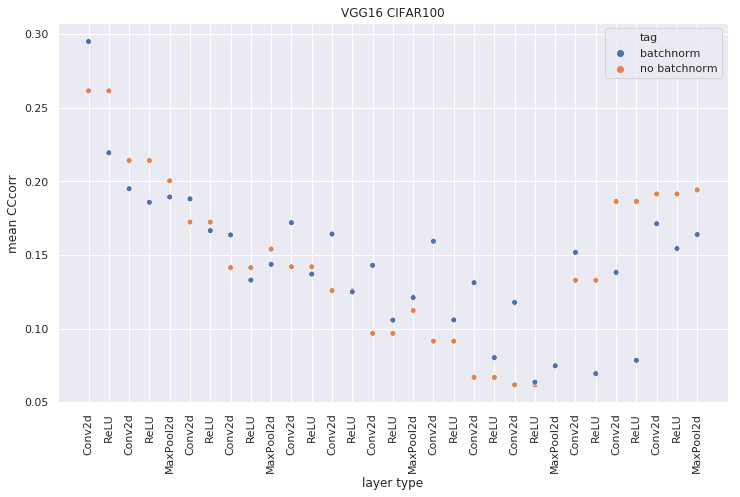

In [183]:
def display(df, measure, coding, title, dims=(12,7)):
    unique_tags = np.unique(df.tag.values)
    data = df[
        (df['measure']==measure) &
        (df['coding']==coding)
    ].sort_values(by=['layer number']).copy()
    
    for unique_tag in unique_tags:
        contiguous_layer_num = make_contiguous(data[data['tag']==unique_tag]['layer number'].values)
        print(contiguous_layer_num)
        data.loc[data['tag']==unique_tag, 'layer number'] = contiguous_layer_num
    
    # re sort by layer number, as everything will be shifted if one set was not contiguous
    data = data.sort_values(by=['layer number'])
    
    fig, ax = plt.subplots(figsize=dims)

    ax = sns.scatterplot(x="layer number", 
                         y="value", 
                         ax=ax,
                         hue="tag",
                         data=data)
    ax.set_title(title)
    ax.set_ylabel('mean {}'.format(measure.replace('_vec','')))
    ax.set_xticks(ticks=range(len(data.type)/len(unique_tags)))
    ax.set_xticklabels(data.type.values[::len(unique_tags)],rotation=90)
    ax.set_xlabel('layer type')
    return data
    
data = display(df_filtered, v, 'features', 'VGG16 CIFAR100')

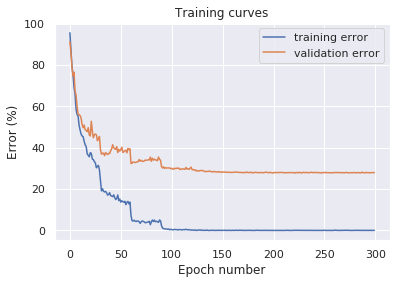

In [244]:
DATA_DIR = "../vgg-feature-gen/CIFAR100/"
log = "log_drop_0_vgg16_bn"

def get_losses(log, epochs=300):
    f = open(DATA_DIR+log)
    val_loss = 100-np.array([float(line.split(' ')[3]) for line in f if " * Prec@1" in line])
    f = open(DATA_DIR+log)
    train_loss = np.array([float(line.split(" ")[8]) for line in f if ("Prec@1" in line) & ("Epoch" in line)])
    step_num = len(train_loss)/epochs
    train_loss = 100-np.array([train_loss[i*step_num:i*step_num+step_num].mean() for i in range(epochs)])
    
    return train_loss, val_loss

def plot_losses(log):
    train_loss, val_loss = get_losses(log)
    ax = pd.DataFrame(columns=['training error', 'validation error'], data=np.array([train_loss, val_loss]).T).plot()
    ax.set_xlabel('Epoch number')
    ax.set_ylabel('Error (%)')
    ax.set_title('Training curves')
    
plot_losses(log)

In [216]:
DATA_DIR = "../vgg-feature-gen/CIFAR100/"
log = "log_drop_0_vgg16_bn"
f = open(DATA_DIR+log)
train_loss = np.array([float(line.split(" ")[6]) for line in f if ("Prec@1" in line) & ("Epoch" in line)])
train_loss.size

3000

In [218]:
len(train_loss)/300

10

In [226]:
step_num = len(train_loss)/300
train_loss_r = np.array([train_loss[i*step_num:i*step_num+step_num].mean() for i in range(300)])
train_loss_r

array([4.19877e+00, 3.63901e+00, 3.23557e+00, 2.91744e+00, 2.58878e+00,
       2.38050e+00, 2.19740e+00, 2.01282e+00, 1.97745e+00, 1.82911e+00,
       1.71407e+00, 1.63237e+00, 1.58841e+00, 1.59938e+00, 1.54330e+00,
       1.45053e+00, 1.42706e+00, 1.31120e+00, 1.29546e+00, 1.22409e+00,
       1.30071e+00, 1.25699e+00, 1.21289e+00, 1.16971e+00, 1.16866e+00,
       1.12596e+00, 1.08702e+00, 1.06897e+00, 1.02003e+00, 9.88600e-01,
       8.07130e-01, 6.21320e-01, 6.52760e-01, 6.20350e-01, 6.19390e-01,
       6.19160e-01, 5.92920e-01, 5.73720e-01, 5.69930e-01, 5.90910e-01,
       5.66900e-01, 5.43530e-01, 5.34100e-01, 5.38010e-01, 5.03400e-01,
       5.01420e-01, 5.10240e-01, 5.48620e-01, 4.62350e-01, 4.94820e-01,
       4.45040e-01, 4.84140e-01, 4.57130e-01, 4.38420e-01, 4.69040e-01,
       4.23840e-01, 4.28770e-01, 4.47530e-01, 4.04410e-01, 4.29480e-01,
       2.38180e-01, 1.55120e-01, 1.40970e-01, 1.52600e-01, 1.33430e-01,
       1.26480e-01, 1.46670e-01, 1.33440e-01, 1.27770e-01, 1.161

In [127]:
def get_paths(target_dir, strings):
    paths = os.listdir(target_dir)
    return sort([path for path in paths if match_strings(strings,path)])

def match_strings(strings, path):
    return all([string in path for string in strings])

path1 = 'abc_123_zxc'
path2 = 'abc_123_cxz'
strings = ['abc','123', 'zx']
match_strings(strings, path1), match_strings(strings, path2)

(True, False)